# Supervised machine learning: Introduction and regularization 
## Binary classification with text data

# Imports

In [1]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *
import pickle

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

In [2]:
## function to process text
def processtext(one_str, stop_list):
    
    ## remove stopwords
    no_stop = [tok for tok in wordpunct_tokenize(one_str)
              if tok not in stop_list]
    
    
    processed_string = " ".join([porter.stem(i.lower()) 
                        for i in no_stop if 
                        i.lower().isalpha() and len(i) >=3])
    return(processed_string)

## function to create dtm
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out())
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

# Load data

Load labeled yelp data in `public_data` and run below code

**Note**: make sure to change your path if you need to; if you're having trouble loading the `pkl`, try running on jupyter hub since it may be a python versioning issue

In [3]:
# If you have trouble loading these data (kernel dies due to memory issues), try sampling down to 5000 or 1000 rows
yelp = pd.read_pickle("../public_data/yelp_forML.pkl") #.sample(n=1000)

In [4]:
## preprocess data to create dtm
porter = PorterStemmer()
list_stopwords = stopwords.words("english")

yelp['process_text'] = [processtext(one_review, stop_list = list_stopwords) 
                        for one_review in yelp['raw_text']]

yelp_dtm = create_dtm(yelp['process_text'], yelp[['metadata_label', 'metadata_rowid',
                                                 'process_text', 'raw_text']])

# 1. Split into features, labels, and split into training/hold out

## 1.1 Split into X (features or id metadata) and y (labels)

In [5]:
X = yelp_dtm[[col for col in yelp_dtm.columns if col not in ['metadata_label',
                                                            'index']]].copy()
y = yelp_dtm[['metadata_label']]

In [6]:
## checking dimensionality
X.shape
y.shape

assert X.shape[0] == y.shape[0]
assert y.shape[1] == 1


(15000, 23439)

(15000, 1)

## 1.2 using automatic function to create train-test split

In [7]:
### using built-in function
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   random_state = 221)

## 1.3 using more manual approach to create train-test split

In [18]:
### more manually: useful when we want more control
### over the ids (eg clustering or time ordering)
### or if we want to go back to matrix before preprocessing
nrows_train = round(X.shape[0]*0.8)
nrows_test = X.shape[0] - nrows_train
random.seed(221)
train_ids = random.sample(list(set(X['metadata_rowid'])), nrows_train)

def my_split(X, y, 
             train_ids, 
             id_col):
    
    ## get test ids
    test_ids = set(X[id_col]).difference(train_ids)
    
    ## split
    X_train_man = X[X[id_col].isin(train_ids)].copy()
    X_test_man = X[X[id_col].isin(test_ids)].copy()
    y_train_man = y[y.index.isin(train_ids)].iloc[:, 0].to_numpy()
    y_test_man = y[y.index.isin(test_ids)].iloc[:, 0].to_numpy()
    
    ## return
    return(X_train_man, X_test_man, y_train_man, y_test_man)

In [19]:
X_train_man, X_test_man, y_train_man, y_test_man = my_split(train_ids, 
                                                           'metadata_rowid')

# 2. Estimate models with hardcoded parameters: logistic regression with L1 regularization (Lasso)

## 2.1 Estimate model using training data

In [10]:

non_feat = ['metadata_rowid', 'raw_text', 'process_text']
logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = 0.01, solver='liblinear')
logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

## 2.2 Generate predictions in test data

In [11]:
y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [12]:
## print the results 
y_pred[0:5]
y_predprob[0:5]


array([0, 0, 1, 0, 0])

array([[0.64280182, 0.35719818],
       [0.69705284, 0.30294716],
       [0.06365578, 0.93634422],
       [0.72127594, 0.27872406],
       [0.50401996, 0.49598004]])

## 2.3 Clean up predictions and calculate error metrics

,y_pred_binary,y_pred_continuous,y_true
656,0,0.240261,0
825,1,0.698197,1
1641,1,0.790615,1
2249,1,0.535262,1
1080,0,0.448135,0
2490,0,0.432774,1
2857,1,0.679593,1
1160,1,0.681806,1
1061,1,0.519505,0
2255,0,0.193031,0


/opt/conda/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.


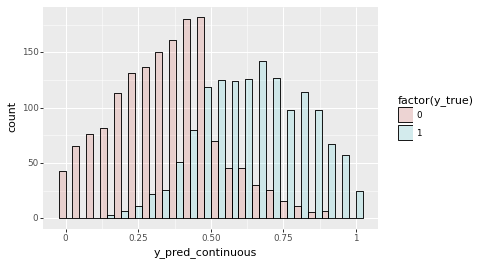

<ggplot: (8777137769659)>

In [13]:
## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)

## plot prob versus true
(ggplot(y_pred_df, aes(x = 'y_pred_continuous', group = 'factor(y_true)',
                      fill = 'factor(y_true)')) +
geom_histogram(alpha = 0.2, position = "dodge", color = 'black'))


In [23]:
## precision as tp / tp+fp 
error_cond = [(y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
             (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
              (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")
y_error = y_pred_df.error_cat.value_counts().reset_index().copy()
y_error.columns = ['cat', 'n']
y_error

### precision
print("Precision is:-----------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])

### recall
print("Recall is:---------------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FN", 'n'].iloc[0])

,cat,n
0,TN,1320
1,TP,1103
2,FN,319
3,FP,258


Precision is:-----------


0.8104335047759

Recall is:---------------


0.7756680731364276

## 2.4 Interpret the model

In [15]:
## get top features
las_coef = pd.DataFrame({'coef': logit_lasso.coef_[0],
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
las_coef.sort_values(by = 'coef', ascending = False)


top_feat = las_coef.sort_values(by = 'coef', ascending = False)[0:10]
top_feat_list = top_feat.feature_name.to_list()

all_agg = [yelp_dtm.groupby(['metadata_label']).agg({one_feat: np.mean})
for one_feat in top_feat_list]
all_agg_df = pd.concat(all_agg, axis = 1)
all_agg_df

,coef,feature_name
5009,0.839733,delici
8170,0.780729,great
11104,0.614038,love
526,0.444977,amaz
6510,0.399717,excel
...,...,...
20768,-0.303388,terribl
21101,-0.309590,told
14032,-0.362058,noth
1251,-0.381803,bad


,delici,great,love,amaz,excel,best,favorit,friendli,definit,alway
metadata_label,,,,,,,,,,
0,0.026424,0.171178,0.085976,0.022944,0.018819,0.103506,0.027713,0.067672,0.059036,0.113302
1,0.162248,0.557305,0.284452,0.104529,0.093621,0.219691,0.116819,0.169014,0.142640,0.242613


# 3. Comparing perf across diff hyperparameters: logistic regression with L1 regularization (Lasso)

In [16]:
c_list = np.linspace(4, 0.001, 10)

## define function that takes in one cost parameter
## and estimates model, returning pred
def one_las(one_c):
    one_lasso = LogisticRegression(penalty = "l1", max_iter=100, 
             C = one_c, solver='liblinear')
    one_lasso.fit(X_train_man[[col for col in X_train.columns if 
                              col not in non_feat]], y_train_man)
    y_pred = one_lasso.predict(X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]])
    y_pred_df = pd.DataFrame({'y_pred': y_pred, 
                             'y_true': y_test_man,
                             'cost': one_c})
    return(y_pred_df)

In [17]:
## bind into one dataframe 
all_pred = [one_las(one_c) for one_c in c_list]
all_pred_df = pd.concat(all_pred)

## score one cost level 
def score_onedf(one_c, all_c):
    one_df = all_c[all_c.cost == one_c].copy()
    prec_onec =  precision_score(
        one_df['y_true'], one_df['y_pred'], 
        zero_division = 0)
    return(prec_onec)
    
all_score = pd.DataFrame({'cost': c_list,
                         'precision': [score_onedf(one_c, all_pred_df) 
                                  for one_c in c_list]})
all_score

all_score[all_score.precision == np.max(all_score.precision)]

,cost,precision
0,4.000000,0.860594
1,3.555667,0.000000
2,3.111333,0.000000
3,2.667000,0.000000
4,2.222667,0.000000
5,1.778333,0.000000
6,1.334000,0.000000
7,0.889667,0.000000
8,0.445333,0.000000
9,0.001000,0.000000


,cost,precision
0,4.0,0.860594


# 4. Activity 

- Read the documentation here to initialize a ridge regression (l2 penalty)- you can use the same cost parameter (C) and number of iterations as in the lasso example above: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Fit the model on X_train_man, y_train_main 
- Generate binary and continuous predictions
- Create a function that takes in a dataframe of binary predictions and true labels and manually calculates the $F_{1}$ score:

$$F_{1} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$$

- Apply that function to calculate the F1 score for the decision tree and lasso (from above), and ridge regression (from the activity)
- *Challenge exercise*: parametrize the model fitting with a function that takes in a classifier as an argument and returns coefficients or feature importances and certain eval metrics (eg precision, recall, and F1)

In [ ]:
# your code here 

### Extra challenge

Text vectorization methods affect downstream classification accuracy. Above, we used simple term counts to turn texts into numbers. This time, instead of using term frequencies, use `sklearn`'s `TfidfVectorizer()` function to weight features with term frequency inverse document frequency (TF-IDF): this gives a word greater weight both when it is more frequent in a text AND when it is rare across the corpus. Does this vectorization approach improve classification accuracy?

In [ ]:
# your code here